In [1]:
import numpy as np
import keras
from keras import layers
from keras import optimizers
from keras.layers import *
from keras.models import Model
from hier_attention_mask import Attention
from keras import backend as K
#from Bio.Blast.Applications import NcbipsiblastCommandline
#from Bio import SeqIO
from keras.metrics import categorical_accuracy, binary_crossentropy
import matplotlib.pyplot as plt
import os
import calendar
import time
import argparse
import sys
#from utils_cnn_CS import *
#from utils_gruCS import *
from utils_res_CS import *

Using TensorFlow backend.


In [2]:
def process_eachseq(seq,pssmfile,mask_seq,new_pssms):
    seql = len(seq)
    if os.path.exists(pssmfile):
        print("found " + pssmfile + "\n")
        pssm = readPSSM(pssmfile)
    else:
        print("using Blosum62\n")
        pssm = convertSampleToBlosum62(seq)
        #pssm = convertSampleToCBOW(seq)
    pssm = pssm.astype(float)
    PhyChem = convertSampleToPhysicsVector_pca(seq)
    pssm = np.concatenate((PhyChem, pssm), axis=1)
    if seql <= 1000:
        padnum = 1000 - seql
        padmatrix = np.zeros([padnum, 25])
        pssm = np.concatenate((pssm, padmatrix), axis=0)
        new_pssms.append(pssm)
        mask_seq.append(gen_mask_mat(seql, padnum))
    else:
        pssm = np.concatenate((pssm[0:500, :], pssm[seql - 500:seql, :]), axis=0)
        new_pssms.append(pssm)
        mask_seq.append(gen_mask_mat(1000, 0))

In [3]:
def endpad(seqfile, pssmdir=""): #定义endpad(序列文件，pssm路径)
    new_pssms = []
    mask_seq = []
    ids=[]
    seqs=[]
    f = open(seqfile, "r")  #f为打开序列文件
    line = f.readline()  #读取序列文件的第一行
    while line != '':
        pssmfile = pssmdir + line[1:].strip() + "_pssm.txt"  #pssm文件名=pssm地址+id名+_pssm.txt
        if line[0] == '>':  #如果该行第一个字符为>
            id = line.strip()[1:]  #id为去掉>的字符
            ids.append(id)   #在id空列表中添加id
        seq = f.readline().strip()  #第一次seq为第2行的内容，实际seq为>行的下一行
        seqs.append(seq)
        process_eachseq(seq,pssmfile,mask_seq,new_pssms)
        line = f.readline()  #继续读取下一行，即>行
    x = np.array(new_pssms)  #把new_pssms列表变为数组，赋给x
    mask = np.array(mask_seq)  #把mask_seq（标注的序列？）转化为数组
    return [x,mask,ids]  #返回pssm矩阵，类别，标注序列，名字id
  

In [4]:
map_lv2={1.0:"Cytoplasmic vesicle",1.1:"Cytoplasm, cytoskeleton",1.2:"Cytoplasm, myofibril",1.3:"Cytoplasm, cytosol",1.4:"Cytoplasm, perinuclear region",
         1.5:"Cytoplasm, cell cortex",1.6:"Cytoplasmic granule",1.7:"Cytoplasm, P-body",
         0.0:"Nucleus, nucleolus",0.1:"Nucleus, nucleoplasm",0.2:"Nucleus membrane",0.3:"Nucleus matrix",0.4:"Nucleus speckle",0.5:"Nucleus, PML body",
         0.6:"Nucleus, Cajal body",0.7:"Chromosome",
         3.0:"Mitochondrion inner membrane",3.1:"Mitochondrion intermembrane space",3.2:"Mitochondrion outer membrane",3.3:"Mitochondrion matrix",
         3.4:"Mitochondrion membrane",
         5.0:"Endoplasmic reticulum lumen",5.1:"Endoplasmic reticulum membrane",5.2:"Endoplasmic reticulum-Golgi intermediate compartment",
         5.3:"Microsome",5.4:"Sarcoplasmic reticulum",
         2.0:"Secreted, exosome",2.1:"Secreted, extracellular space",
         7.0:"Golgi apparatus, trans-Golgi network",7.1:"Golgi apparatus, cis-Golgi network",7.2:"Golgi apparatus membrane",7.3:"Golgi apparatus, Golgi stack membrane",
         4.0:"Membrane, clathrin-coated pit",4.1:"Membrane, coated pit",4.2:"Membrane raft",4.3:"Membrane, caveola",4.4:"Cell membrane",4.5:"Cell surface",
         8.0:"Lysosome membrane",
         9.0:"Peroxisome membrane",
         6.0:"Plastid, amyloplast",6.1:"Plastid, chloroplast membrane",6.2:"Plastid, chloroplast stroma",6.3:"Plastid, chloroplast thylakoid lumen",
         6.4:"Plastid, chloroplast thylakoid membrane"
         }

In [5]:
name=["Nucleus","Cytoplasm","Secreted","Mitochondrion","Membrane","Endoplasmic","Plastid","Golgi_apparatus","Lysosome","Peroxisome"]

In [6]:
def main():
    parser=argparse.ArgumentParser(description='MULocDeep: interpretable protein localization classifier at sub-cellular and sub-organellar levels')
    parser.add_argument('-input',  dest='inputfile', type=str, help='protein sequences in fasta format.', 
                        default = "E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/预测结果/data/lv1_test.txt",
                        required=False)
    parser.add_argument('-output',  dest='outputdir', type=str, help='the name of the output directory.', 
                        default = "E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/预测结果/predict_4",
                        required=False)
    parser.add_argument('-existPSSM', dest='existPSSM', type=str,
                        help='the name of the existing PSSM directory if there is one.', required=False,
                        #default = "E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/预测结果/data/test_pssm_empty/")
                        default="E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/")
    parser.add_argument('--att', dest='drawATT', action='store_false',
                        help='Draw attention weight plot for each protein.', required=False)
    parser.add_argument('--no-att', dest='drawATT', action='store_true',
                        help='No attention weight plot.', required=False)
    parser.set_defaults(feature=True)
    args = parser.parse_known_args()[0]   #jupyter下运行解析需要此代码
    att_draw=args.drawATT
    inputfile=args.inputfile
    outputdir=args.outputdir
    
    if not outputdir[len(outputdir) - 1] == "/":
        outputdir = outputdir + "/"
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    existPSSM=args.existPSSM
    if existPSSM!="":
        if not existPSSM[len(existPSSM) - 1] == "/":
            existPSSM = existPSSM + "/"

    if ((existPSSM=="")or(not os.path.exists(existPSSM))):
        ts = calendar.timegm(time.gmtime())
        pssmdir=outputdir+str(ts)+"_pssm/"
        if not os.path.exists(pssmdir):
            os.makedirs(pssmdir)
        process_input_user(inputfile,pssmdir)  # generate pssm
        [test_x, test_mask, test_ids] = endpad(inputfile, pssmdir)
    else:
        [test_x, test_mask, test_ids] = endpad(inputfile, existPSSM)

    pred_big = np.zeros((test_x.shape[0],10))
    att_matrix_N = np.zeros((8, test_x.shape[0], 1000))
    cross_pred_small = np.zeros((test_x.shape[0], 8, 10, 8))

    for foldnum in range(8):
        model_big, model_small = singlemodel(test_x)
        model_small.load_weights('E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/预测结果/lv1_result4/fold' + str(foldnum) + '_big_lv1_acc-weights.hdf5')
        
        cross_pred_small[:, foldnum]= model_small.predict([test_x, test_mask.reshape(-1, 1000, 1)])[0]
        model_att = Model(inputs=model_big.inputs, outputs=model_big.layers[-11].output[1])
        att_pred = model_att.predict([test_x, test_mask.reshape(-1, 1000, 1)])
        att_matrix_N[foldnum, :] = att_pred.sum(axis=1) / 41

    att_N = att_matrix_N.sum(axis=0) / 8

    pred_small = cross_pred_small.sum(axis=1) / 8 #[?,10,8]
    pred_small_c = pred_small.copy()
    pred_big_c=pred_small_c.max(axis=-1)   #[?, 10]
    
    '''cutoff = np.array([[0.5, 0.5, 0.5, 0.3, 0.5, 0.4, 0.3, 0.5],
                  [0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.5, 0.3],
                  [1, 0.5, 1, 1, 1, 1, 1, 1],
                  [0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 1],
                  [0.5, 0.1, 0.4, 0.4, 0.4, 0.3, 1, 1],
                  [0.4, 0.5, 0.5, 0.5, 0.4, 1, 1, 1],
                  [0.5, 0.5, 0.5, 0.1, 0.5, 1, 1, 1],
                  [0.1, 0.1, 0.5, 0.3, 1, 1, 1, 1],
                  [0.3, 1, 1, 1, 1, 1, 1, 1],
                  [0.4, 1, 1, 1, 1, 1, 1, 1]])'''   #gru-pssm
    cutoff = np.array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                      [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75],
                      [0.7, 0.7, 1, 1, 1, 1, 1, 1],
                      [0.28, 0.28, 0.28, 0.28, 0.28, 1, 1, 1],
                      [0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 1, 1],
                      [0.4, 0.5, 0.5, 0.5, 0.4, 1, 1, 1],
                      [0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 1],
                      [0.5, 0.5, 0.5, 0.5, 1, 1, 1, 1],
                      [0.79, 1, 1, 1, 1, 1, 1, 1],
                      [0.4, 1, 1, 1, 1, 1, 1, 1]])  #cnn-gru-pssm
    '''cutoff = np.array([[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
                  [0.1, 0.1, 0.751, 0.1, 0.1, 0.1, 0.1, 0.1],
                  [0.2, 0.2, 1, 1, 1, 1, 1, 1],
                  [0.74, 0.74, 0.74, 0.74, 0.74, 1, 1, 1],
                  [0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 1, 1],
                  [0.7, 0.7, 0.7, 0.7, 0.7, 1, 1, 1],
                  [0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 1],
                  [0.3, 0.3, 0.3, 0.3, 1, 1, 1, 1],
                  [0.185, 1, 1, 1, 1, 1, 1, 1],
                  [0.21, 1, 1, 1, 1, 1, 1, 1]]) '''  #cnn-gru-cbow
        
    pred_small[pred_small >= cutoff]=1.0
    pred_small[pred_small < cutoff] =0.0
    for i in range(pred_small.shape[0]):
        index=((pred_small_c[i]>=cutoff).sum(axis=-1))>0
        pred_big[i][index] =1.0
        if pred_small[i].sum() == 0:
            index = pred_small_c[i].max(axis=-1).argmax()
            index2 = pred_small_c[i][index].argmax()
            pred_small[i][index, index2] = 1.0
            pred_big[i][index] = 1.0
                
    #sub-cellular results
    f0 = open(outputdir+"test_pred.txt","w")
    f1 = open(outputdir+"sub_cellular_prediction.txt", "w")
    ind = 0
    for i in test_ids:
        f1.write(">" + i + ":\t")
        ans = ""
        a = ""
        for j in range(10):
            f1.write(name[j] + ":" + str(pred_big_c[ind, j]) + "\t")
            if pred_big[ind, j] == 1.0:
                if j == 0:
                    ans = ans + "Nucleus|"
                    a = a + "0.0;"
                elif j == 1:
                    ans = ans + "Cytoplasm|"
                    a = a + "1.0;"
                elif j == 2:
                    ans = ans + "Secreted|"
                    a = a + "2.0;"
                elif j == 3:
                    ans = ans + "Mitochondrion|"
                    a = a + "3.0;"
                elif j == 4:
                    ans = ans + "Membrane|"
                    a = a + "4.0;"
                elif j == 5:
                    ans = ans + "Endoplasmic|"
                    a = a + "5.0;"
                elif j == 6:
                    ans = ans + "Plastid|"
                    a = a + "6.0;"
                elif j == 7:
                    ans = ans + "Golgi_apparatus|"
                    a = a + "7.0;"
                elif j == 8:
                    ans = ans + "Lysosome|"
                    a = a + "8.0;"
                elif j == 9:
                    ans = ans + "Peroxisome|"
                    a = a + "9.0;"
        f1.write("prediction:" + ans + "\n")
        f0.write(a + "\n")
        ind = ind + 1
    f1.close()
    f0.close()

    # sub-organellar results
    f1 = open(outputdir+"sub_organellar_prediction.txt", "w")
    ind = 0
    for i in test_ids:
        f1.write(">" + i + ":\t")
        ans = ""
        for j in range(10):
            for z in range(8):
                key = float(str(j) + "." + str(z))
                if key in map_lv2:
                    f1.write(map_lv2[key] + ":" + str(pred_small_c[ind, j, z]) + "\t")
                    if pred_small[ind, j, z] == 1.0:
                        ans = ans + map_lv2[key] + "|"
        f1.write("prediction:" + ans + "\n")
        ind = ind + 1
    f1.close()

    # output attention weights
    f1 = open(outputdir+"attention_weights.txt", "w")
    ind=0
    f = open(inputfile)
    list_seq = f.readlines()
    for i in test_ids:
        end = int(test_mask[ind].sum())
        j = ind * 2 + 1
        seq = list(list_seq[j].strip())
        f1.write(">" + i + "\n")
        if len(seq) <= 1000:
            for p in att_N[ind][0:end]:
                f1.write(str(p) + " ")
        else:
            dif = len(seq) - end
            w = np.concatenate((att_N[ind][0:500], np.zeros(dif), att_N[ind][500:]), axis=0)
            for p in w:
                f1.write(str(p) + " ")
                f1.write("\n")
        ind=ind+1
    f1.close()

    if att_draw:
        i = 0
        f = open(inputfile)
        list_seq = f.readlines()
        for p in test_ids:
            j = i * 2 + 1
            ind = int(test_mask[i].sum())
            seq = list(list_seq[j].strip())
            plt.xticks(np.linspace(1, len(seq), len(seq)), seq)
            if len(seq)<=1000:
                plt.plot(np.linspace(1, ind, ind), att_N[i][:ind])
            else:
                dif=len(seq)-ind
                w=np.concatenate((att_N[i][0:500],np.zeros(dif),att_N[i][500:]),axis=0)
                plt.plot(np.linspace(1, len(seq), len(seq)),w)
                plt.savefig(outputdir+p+'.png')
            i=i+1

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/O97101_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q06278_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P80456_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/G3X982_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/R4ZGN4_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/H9TB17_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/O54754_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P48034_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q5SGK3_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9Z0U5_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/O14139_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q03661_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9VYS4_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q96BY6_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q8IWZ3_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P17927_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q22328_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q2VPA4_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9M0V3_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q805F9_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q8S2T0_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9VHR8_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9VN03_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q6XP49_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q810J8_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9HBF4_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9JJ50_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9UTH3_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P41842_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P53866_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q6P7F1_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9FN69_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/O94614_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P48566_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q12317_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q14258_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/O59698_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9VCR3_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q64MA3_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P40053_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P35520_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/O59701_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P22307_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/G5EDP2_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q17060_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/O77061_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/O18330_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q8N8E2_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9DCD5_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P42073_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P57721_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P04776_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q5XM24_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9NX74_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q00566_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q5RJI4_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q12342_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q61884_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q93Z00_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/O74958_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q09306_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q93VB2_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9Y484_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q5MNZ6_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9SV55_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q924M7_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q8C6P8_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/F4JRR5_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P16330_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/D4APA9_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/B6VQA1_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q86MP3_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q5VZF2_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9NUK0_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P53063_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q2V3L3_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9VWF4_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q8VYD2_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q8BG18_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9XI36_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P49184_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q5U2R6_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9DBN4_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q5VYS4_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q14BA6_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q5JL96_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9FFB6_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q8VZK0_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q10LI1_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9FLT2_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9GKK3_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9BXL8_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/D0NMF6_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/D0NP16_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/D0NIN5_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P51858_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P86947_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/H2A0K6_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q4ZJM9_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/O80683_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q6W0C5_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q7Z713_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9BWK5_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q9SKX1_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/O13563_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P46695_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P0CV07_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/A0A172M416_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/O02372_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P05017_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocD

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P34180_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P0C616_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P0CAS0_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q6P161_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q3MHJ5_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/A0A172M421_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/A0A172M490_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/P53738_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/D0MXE4_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/D0MQL8_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MU

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/A7WNV5_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/Q1JS89_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/C5H0D5_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/E1B230_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/E1B243_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/E7EKI0_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/E1B242_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/C5H0D4_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/C3RT24_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-master/MULocDeep-master/data/test_pssm/C3RT23_pssm.txt

found E:/论文真的非常重要请好好学习/2021.2 MULocDeep-

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 1000, 25)     0                                            
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 1000, 25)     0           Input[0][0]                      
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 1000, 25)     0           dropout_14[0][0]                 
                                                                 input_2[0][0]              

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 1000, 25)     0                                            
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 1000, 25)     0           Input[0][0]                      
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
lambda_29 (Lambda)              (None, 1000, 25)     0           dropout_27[0][0]                 
                                                                 input_3[0][0]              

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 1000, 25)     0                                            
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 1000, 25)     0           Input[0][0]                      
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
lambda_43 (Lambda)              (None, 1000, 25)     0           dropout_40[0][0]                 
                                                                 input_4[0][0]             

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 1000, 25)     0                                            
__________________________________________________________________________________________________
dropout_53 (Dropout)            (None, 1000, 25)     0           Input[0][0]                      
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
lambda_57 (Lambda)              (None, 1000, 25)     0           dropout_53[0][0]                 
                                                                 input_5[0][0]             

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 1000, 25)     0                                            
__________________________________________________________________________________________________
dropout_66 (Dropout)            (None, 1000, 25)     0           Input[0][0]                      
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
lambda_71 (Lambda)              (None, 1000, 25)     0           dropout_66[0][0]                 
                                                                 input_6[0][0]             

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 1000, 25)     0                                            
__________________________________________________________________________________________________
dropout_79 (Dropout)            (None, 1000, 25)     0           Input[0][0]                      
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
lambda_85 (Lambda)              (None, 1000, 25)     0           dropout_79[0][0]                 
                                                                 input_7[0][0]             

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 1000, 25)     0                                            
__________________________________________________________________________________________________
dropout_92 (Dropout)            (None, 1000, 25)     0           Input[0][0]                      
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
lambda_99 (Lambda)              (None, 1000, 25)     0           dropout_92[0][0]                 
                                                                 input_8[0][0]             

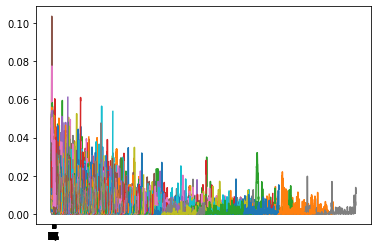

In [7]:
if __name__ == "__main__":
    main()